# Detecting Planets With Kepler Photometry #

by: Isabel Angelo, based on [Lightkurve Tutorial](https://github.com/howardisaacson/Introduction-to-Astronomy-Research/blob/master/Week6/Lightkurve%20Tutorial.ipynb) by Ruben Santana

### Introduction: How does Kepler find exoplanets? ###
The most common method thus far in detecting exoplanets is via the transit method. This method involves using stellar photometry (i.e. mapping the star's brightness as a function of time)  to observe periodic drops in brightness due to a planet passing in front of the star:

![alt text](transit.png "Title")

Most planets found via the transit method have been detected by the *Kepler* space telescope.*Kepler* takes photometric data of ~100,000 stars in the sky at a given time to check for signatures of exoplanets. Thousands of planets have been discovered by *Kepler* in the past 10 years, and it is by far the most successful planet-finding mission to date!

For this tutorial, we will download photometric data from *Kepler* that is available online. We will then use the data to detect a planet and determine it's size and temperature.

### Using Lightkurve to Analyze Flux Time-Series Data ###
After *Kepler* takes photometric data, it runs it through a 
[data processing pipeline](https://github.com/nasa/kepler-pipeline/) that prepares the data for analysis. The process files are then made avaiavle on the 
[Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/kepler/data_search/search.php). Here we will use ready and available *Kepler* data from MAST. We will then further process our data using [lightkurve](https://lightkurve.keplerscience.org/index.html), a Python package created specifically for analyzing flux time-series (i.e. photometric) data. 

### Installing Lightkurve ###

We will begin by making sure we have all the python packages needed for the tutorial. First, we will install lightkurve by typing:

`pip install lightkurve`

on the terminal and hitting enter. This should install the package and all the requirements.

### Getting Started: Selecting a Target and Data from the Archives ###

Let's begin by importing the packages we'll need in python:

In [5]:
from lightkurve import KeplerTargetPixelFile, KeplerLightCurveFile, lightcurve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next we want to select the target and quarters to extract from the data archives. We can choose the target star by either using the star ID, kepler-#, or KOI-#. As an example, I am going to use the star-planet system 'KOI-217'. Feel free to explore other systems as you get a better idea of the process!

We also need to choose how many quarters (of a year) of data we want to download. Kepler observed for a total of about 4 years, or 17 quarters. To start we will try using all of the data available for this target (quarters 1-17):

In [6]:
target = 'KOI-217'
qRange = [1,17]

### Reducing and Modifying Data to Create a Light Curve ###

Next we need to upload the data and modify it into a data set that is easy to analyze. This part is a little complicated, so we can walk through it together. For more details, see Ruben's "Lightkurve Tutorial" in this week's files. 

Here we extract a visual data set called TargetPixelFiles (TPFs) and stores them in a list:

In [7]:
%%capture
#List to hold our TargetPixelFile & LightCurveFile
tpfs = []
for q in range(qRange[0],qRange[1]):
    #Note some quarters are missing, so we'll use Python's try/except to avoid crashing
    try:
        tpfs.append(KeplerTargetPixelFile.from_archive(target, quarter=q))
    except:
        continue

Next we will flatten the light curve and remove all the "bad" data points (i.e. outliers and NaN values):

In [8]:
%%capture  
#Build the light curve
pipeline_lc = tpfs[0].to_lightcurve().flatten()
for tpf in tpfs:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten())

#Clean the light curve
pipeline_lc = pipeline_lc.remove_nans()
pipeline_lc = pipeline_lc.remove_outliers()

### Plotting the Pipeline ###

Our data is now ready for analysis! Let's first take a look at the light curve by plotting it:

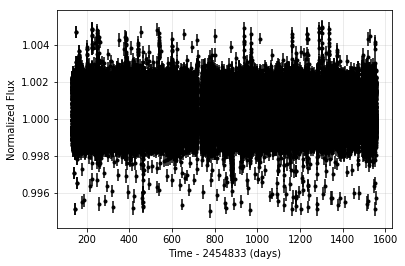

In [9]:
pipeline_lc.plot(fmt='.')

### Find the Period of the Planet ###

Next we want to find the period of the planet so that we know where in the light curve to look for transits. Fortunately, the lightkurve package has a function called iterative_box_period_search that computes lists of possible periods and a "best match", or most accurate estimate of the planet's period.

Read about the function here: 

http://lightkurve.keplerscience.org/api/lightkurve.lightcurve.iterative_box_period_search.html

and run it to extract the period of the planet.

notes: 
1. This code runs through a list of possible periods and tests each one to see which one fits the data the best. To avoid testing through too many unnecessary periods, it is helpful to set min_period and max_period to values close (~1 day) to the actual planet period, which you can find on the [NASA Exoplanet Archive](https://www.google.com/search?q=nasa+exoplanet+archive&oq=nasa+exoplan&aqs=chrome.0.69i59l3j69i57j69i60l2.1519j0j7&sourceid=chrome&ie=UTF-8)

2. The precision of possible periods is determined by the input nperiods, which describes the number of periods that are tested. For our purposes, we need a very precise period, which means we should be testing at least 20,000 periods total to get an accurate measurement.

In [10]:
log_list, trial_periods, period = lightcurve.iterative_box_period_search(lc = pipeline_lc, 
                                                  niters=2, 
                                                  min_period=3, 
                                                  max_period=5, 
                                                  nperiods=20000, 
                                                  period_scale='log')
print(period) 

  0%|          | 0/20000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 20000/20000 [28:32<00:00, 11.68it/s]

3.9049189711461425


### Folding and Binning Data ###

Next we want to perform two functions to our pipline lightcurve (`pipeline_lc`) to the data necessary for extracting a single transit: folding and binning. 

Folding the data means that you superimpose all the transits with the same period on top of one another to output a single transit curve. You can do this by using the lightkurve function .fold() (see function [here]( http://lightkurve.keplerscience.org/api/lightkurve.lightcurve.LightCurve.html#lightkurve.lightcurve.LightCurve.fold)).

We then want to bin the data. Kepler takes tons of observations, so we end up with graphs that have very large amounts of data points. Binning averages multiple data points together so that our graph has a reasonable number of points. This can be done with the .bin() function (see function [here](http://lightkurve.keplerscience.org/api/lightkurve.lightcurve.LightCurve.html#lightkurve.lightcurve.LightCurve.fold)):


In [11]:
folded_lc = pipeline_lc.fold(period=period, phase=0)
final_lc = folded_lc.bin()

Next, plot your folded and binned light curve to see the final transit! You may want to change the x limits of the graph using plt.xlim() to get a better view of the transit alone. Your plot should resemble the graph in the figure of a transit at the top of this tutorial. 

(0, 0.35)

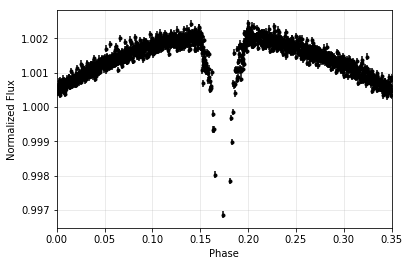

In [12]:
final_lc.plot(fmt='.')
plt.xlim(0,0.35)

### Determing the Planet Size from a Transit ###

One of the main planet properties we can know from the light curve is the planet size. The transit depth $d$ is related to the planet radius $R_p$ as follows:

$d = \frac{\Delta F}{F} = (\frac{R_p}{R_*})^2$

where $R_p$ is the planet radius, $R_*$ is the radius of the host star, and $\frac{\Delta F}{F}$ is the normalized transit depth (where $F_{in}$ and $F_{out}$ refer to the flux in and out of transit, respectively):

$\frac{\Delta F}{F} = \frac{F_{out}-F_{in}}{F_{out}}$ 

We can therefore calculate the planet radius if we know the transit depth and radius of the host star. 

Compute the transit depth in the cell below. You can do this analytically using values from the final_lc array, or alternatively by your own inspection of the graph.

In [13]:
depth = (np.max(folded_lc.flux)-np.min(folded_lc.flux))/np.max(folded_lc.flux)
print(depth)

0.009876202121168203


Plug this depth in to the transit depth equation to get the planet radius. You can get the stellar radius from the NASA exoplanet archive. 

note: make sure you are using consistent units!! It will be helpful to convert your final planet radius into Earth radii so you can compare it to the value listed for the planet on the archive.

In [14]:
Rearth = 637100000.0 
Rsun = 69600000000.0
Rstar = 0.86*Rsun

Rp = np.sqrt(depth)*Rstar
Rp=Rp/Rearth
print('Rp = ', Rp,'Earth radii')

Rp =  9.33673581384858 Earth radii


### Calculating the Planet's Orbital Semi-Major Axis ###

Another thing we can learn from transit photometry is the planet's orbital semi-major axis, or distance from it's host star. We can do this using the period in [Kepler's 3rd Law of Planetary Motion](https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion):

$\frac{T^2}{a^3} = \frac{4\pi^2}{G(M_*+M_p)} \approx \frac{4\pi^2}{GM_*}$

Where $T$ is the orbital period and $a$ is the semi-major axis. Use this equation to solve for a. Once again, be wary of units and try to compute your answer in AU and confirm with the value listed in the exoplanet archive.

In [15]:
Msun = 1.99e+33
G = 6.67e-08
Mstar = 0.95*Msun
T = period*24*3600

a = ((T**2.*G*Mstar)/(4*np.pi**2.))**(1/3.)
AU = 14960000000000.0
ap = a/AU

print('ap = ', ap,'AU')

ap =  0.04770894856159561 AU


Congratualations, you've officially detected a planet and extracted it's size and orbital distance with *Kepler* data! 

### Bonus Round: Stellar Flux Recieved Relative to Earth ###

In the interest of habitability, it is helpful to learn about how much star light the planet receives relative to Earth. If it receives a relatively similar amount, we consider the planet to be within the star's habitable zone. 

The flux recieved by the planet from the host star can be modeled as follows:

$F = \frac{L_\odot}{4\pi a^2}$

where $a$ is the orbital semi-major axis. Calculate the flux received by our planet and convert it into flux received relative to that received by Earth from the Sun. If you can't find the star's luminosity online, you can use an estimate of luminosities for stars of the same star type. Is our planet in the habitable zone?

In [16]:
Lsun = 3.9e+33
L = 0.73*Lsun
Fearth = Lsun/(4*np.pi*AU**2.)
F = L/(4*np.pi*a**2.)
F_rel = F/Fearth
print('F_rel = ', F_rel,'times the flux received by Earth')

F_rel =  320.717877625542 times the flux received by Earth


You've done it! Feel free to plug in different exoplanet systems for "target" and change subsequent cells accordingly to find information about other known exoplanets. 